## 요약
1. EDA
2. 다양한 형태소 분석기 비교 -> soynlp 활용  ( 채용공고 텍스트의 도메인 단어들을 고려하여 비지도 학습을 지향하는 soynlp 활용)
3. soynlp를 활용하여 토큰화 및 명사 추출 진행.


### 필요한 module import 및 데이터, 불용어 사전 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# colab 한글 폰트

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
!pip install konlpy
!pip install soynlp

In [ ]:
#mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.


In [ ]:
cd /content/drive/MyDrive/응용통계학과 공모전/Mecab-ko-for-Google-Colab/

/content/drive/.shortcut-targets-by-id/1pn4VcHanHdtiBk3ljkzfs6sWB11puj3k/응용통계학과 공모전/Mecab-ko-for-Google-Colab


In [ ]:
# 좀 걸림
#!bash install_mecab-ko_on_colab_light_220429.sh

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import math
from wordcloud import WordCloud
from tqdm import tqdm
import re

from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.tag import Mecab
from konlpy.tag import Hannanum
from konlpy.tag import Komoran

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/응용통계학과 공모전/data/wanted_real_final_preprocessed1.csv')
df.head()

,공고명,직무,업종,유사 직무,회사명,회사소개,주요업무,자격요건,우대사항,혜택 및 복지,기술스택,기술스택_long,combined_token,combined
0,"AI, ML Engineer 박사급",머신러닝 엔지니어,"IT, 컨텐츠","데이터 엔지니어,머신러닝 엔지니어",플리토,플리토는 유수의 글로벌 IT 기업들과 함께 언어 장벽 없는 세계를 만들어 가고 있는...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,"AI , ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분\n ML ...",모델을 직접 만들었거나 공개된 모델을 finetuning해서 성능을 향상시킨 경험이...,"- 상호 존중하는 문화\n : 직급 없는 \""님\"" 호칭 및 경어 사용, 자율 ...",Github\n Android\n Firebase\n Kotlin\n Coroutine,Github 에 대한 이해도가 있으신 분\n Android 사용 경험이 있으신 분\...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다 ...
1,AI 컴파일러 개발자 (1년 이상),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,티에스엔랩,"실시간 AI, 실시간 통신 전문 기업 TSN Lab에서 네트워크 AI 개발자를 모십...",\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n,\n 웬만한 중견기업 못지 않은 복지 정책을 지원\n 임직원 연차 구분 없이 20일...,NaN,[연봉은 어떻게 되나요?]\n• 경력자의 경우 기존의 경력과 동일한 분야인 경우 기...,NaN,NaN,\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n\n\n 웬만한 중...,MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다 웬만한 중견기업 못지 않...
2,LLM 연구원 (자연어 처리),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),LLM 연구원 자연어 처리\n\n\n,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n,"경력 3년 이상 또는 관련 학과 석사 학위 소지자\n\nPyTorch, Tenso...","인공지능 관련 대회해커톤, 캐글, 그랜드챌린지 등의 출전 경험 및 입상\n\nM...",1. 유연 근무제\n2. 자유 복장\n3. 최신 장비\n4. 수평적 조직\n5. 도...,C#\n C\n C++\n WPF,C# 사용 가능자\n C 사용 가능자\n C++ 활용 경험이 있으신 분\n WPF ...,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n\n경...,LLM 모델 연구 및 고도화LLM 연구의 서비스화를 위한 개발 지원경력 3년 이상 ...
3,AI R&D 팀장,머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),AI RD 팀장\n\n\n,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,AI 관련학과 박사학위 소지자 또는 이에 준하는 경력 보유자\n\nLLM 관련 최신...,"AI 관련 Top tier 학회NeurIPS, CVPR, AAAI 등 논문 게재...",1. 유연 근무제\n2. 자유 복장\n3. 최신 장비\n4. 수평적 조직\n5. 도...,C#\n C\n C++\n WPF,C# 다룰 수 있으신 분\n C 활용 경험이 있으신 분\n C++ 사용 가능자\n ...,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,sLLM 모델 연구개발 및 서비스 고도화 sLLM 기반의 서비스 모델 개발 및 튜닝...
4,소프트웨어 엔지니어,머신러닝 엔지니어,"IT, 컨텐츠","웹 개발자,머신러닝 엔지니어,소프트웨어 엔지니어","스타인펠드(Steinfeld,Inc.)",Steinfeldco는 치과 보철치료에 필요한 보철물을 더 효율적으로 제공하기 위해...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,python 또는 TypeScript 로 개발 경험 있으신분\n Open mind ...,성장하는 스타트업에 관심 있으신 분,• 경쟁력 있는 연봉\n - 협의를 통해 충분히 경쟁력 있는 수준의 연봉을 제...,Git\n Firebase\n Google Cloud Platform\n Pytor...,Git 경험이 있으신 분\n Firebase 에 대한 이해도가 있으신 분\n Goo...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,AI 개발보철물 자동 디자인을 위한 AI 모델 개발보철물 자동 디자인 서비스 운영환...


In [ ]:
num_df = pd.DataFrame()

for col in ['공고명', '직무', '업종', '유사 직무', '회사명', '회사소개', '주요업무', '자격요건', '우대사항', '혜택 및 복지']:
    num_df[f'{col}_num'] = (df[col].dropna().map(lambda x: len(x)))

num_df.describe()

,공고명_num,직무_num,업종_num,유사 직무_num,회사명_num,회사소개_num,주요업무_num,자격요건_num,우대사항_num,혜택 및 복지_num
count,1145.000000,1145.000000,1145.000000,1124.000000,1145.000000,1118.000000,1127.000000,1126.000000,1114.000000,1145.000000
mean,20.264629,8.447162,6.606114,22.213523,6.966812,542.435599,213.995563,190.936057,186.290844,439.409607
std,10.519081,1.639507,1.473352,7.881285,4.975353,399.999372,241.328493,134.671443,159.176502,409.664609
min,3.000000,3.000000,2.000000,4.000000,2.000000,14.000000,11.000000,11.000000,6.000000,1.000000
25%,12.000000,8.000000,7.000000,18.000000,4.000000,281.000000,89.000000,108.250000,92.000000,175.000000
50%,18.000000,9.000000,7.000000,26.000000,6.000000,462.000000,149.000000,164.500000,148.000000,318.000000
75%,27.000000,9.000000,7.000000,29.000000,9.000000,730.000000,247.000000,236.000000,228.000000,576.000000
max,56.000000,10.000000,11.000000,39.000000,46.000000,4397.000000,2315.000000,1164.000000,1844.000000,3101.000000


In [ ]:
df.shape

(1145, 14)

In [ ]:
#불용어 처리

#불용어 사전 불러오기
with open('/content/drive/MyDrive/응용통계학과 공모전/data/korean_stopwords_응통.txt','r',encoding='utf-8-sig') as f:
    stopwords_list=[]
    example =f.readlines()
    for line in example:
        stopwords_list.append(line.strip())

#추가하고 싶은 불용어가 있다면 다음과 같이 넣어서 사용
add = ['근무조건','고용형태','근무장소','급여조건','합류','서류','전형','인터뷰','합격','유의사항','공고','모집','채용','정규직','면접','전형','근무시','출근']

#불용어 사전 정의
stop = add+stopwords_list

## EDA

### 직무, 유사 직무

In [ ]:
df.직무.value_counts()

머신러닝 엔지니어     359
데이터 엔지니어      328
데이터 사이언티스트    205
빅데이터 엔지니어     154
DBA            78
BI 엔지니어        21
Name: 직무, dtype: int64

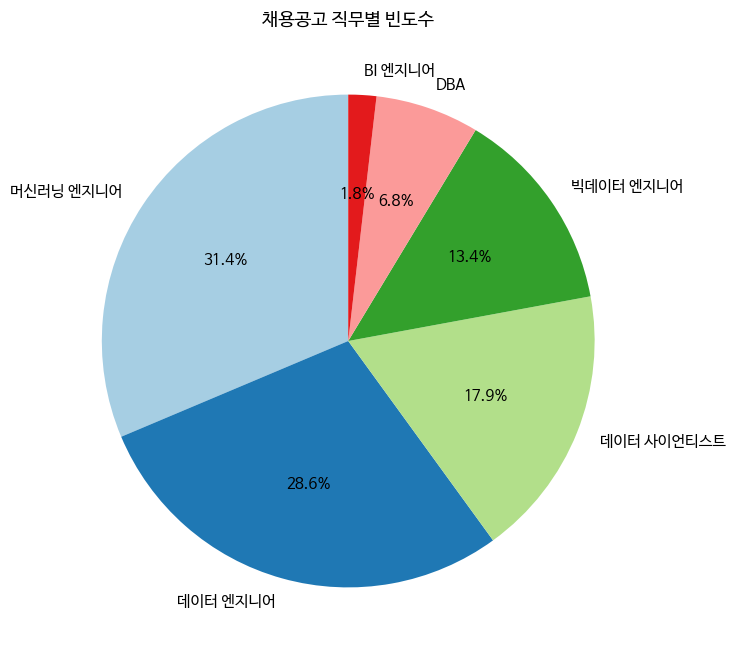

In [ ]:
# 파이차트로 시각화
value_counts_result = df.직무.value_counts()

# 기본 글꼴 크기 설정
plt.rcParams['font.size'] = 11

plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(8, 8))
plt.pie(value_counts_result, labels=value_counts_result.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('채용공고 직무별 빈도수')
plt.show()

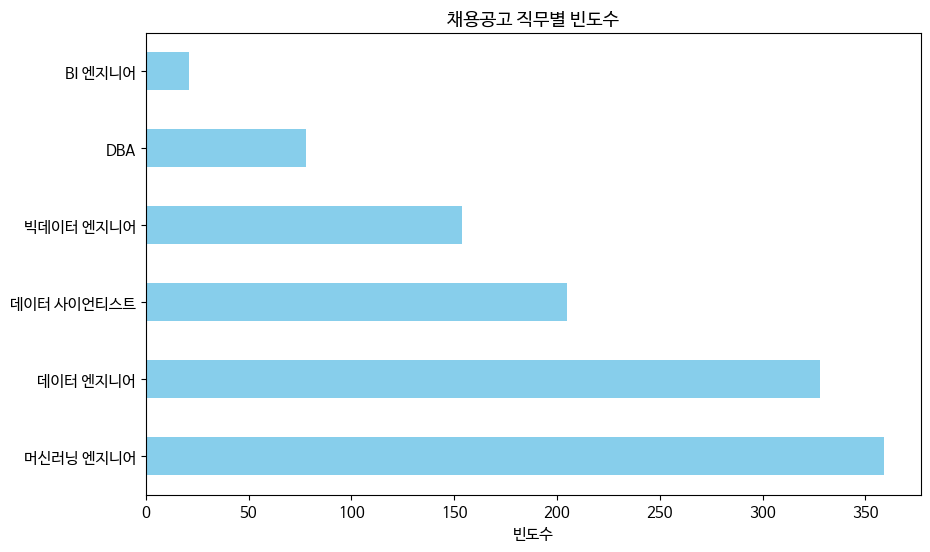

In [ ]:
value_counts_result = df.직무.value_counts()

# 시각화 (horizontal bar plot)
plt.figure(figsize=(10, 6))
value_counts_result.sort_values(ascending = False).plot(kind='barh', color='skyblue')
plt.xlabel('빈도수')
plt.title('채용공고 직무별 빈도수')
plt.show()

In [ ]:
df['유사 직무'] = df['유사 직무'].fillna('')

df1 = df[df.직무 == '머신러닝 엔지니어']
df2 = df[df.직무 == '데이터 엔지니어']
df3 = df[df.직무 == '데이터 사이언티스트']
df4 = df[df.직무 == '빅데이터 엔지니어']
df5 = df[df.직무 == 'DBA']
df6 = df[df.직무 == 'BI 엔지니어']

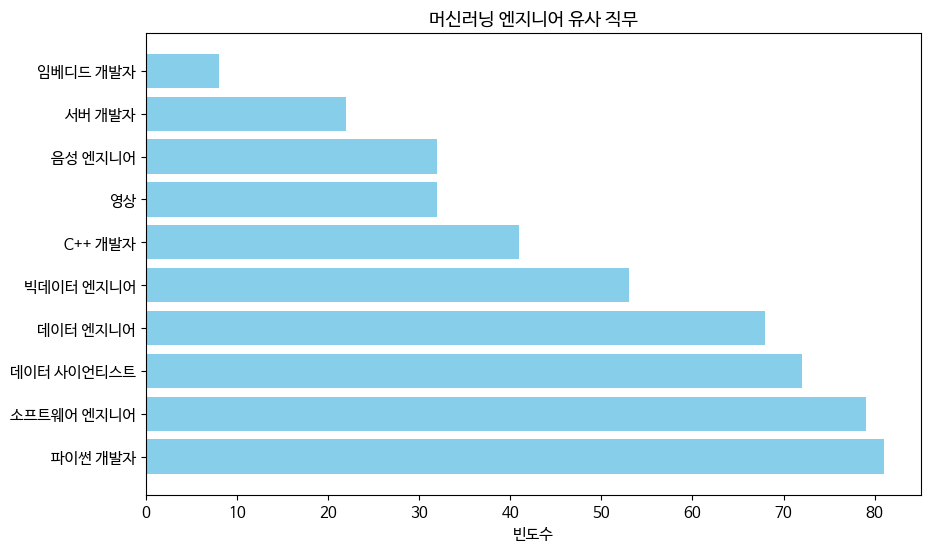

In [ ]:
exclude_job = '머신러닝 엔지니어'

similar_jobs_counter = Counter([job.strip() for jobs in df1['유사 직무'].str.split(',') for job in jobs if job != exclude_job])
top_similar_jobs = similar_jobs_counter.most_common(10)

plt.figure(figsize=(10, 6))
plt.barh([job[0] for job in top_similar_jobs], [job[1] for job in top_similar_jobs], color='skyblue')
plt.xlabel('빈도수')
plt.title(f'{exclude_job} 유사 직무')
plt.show()

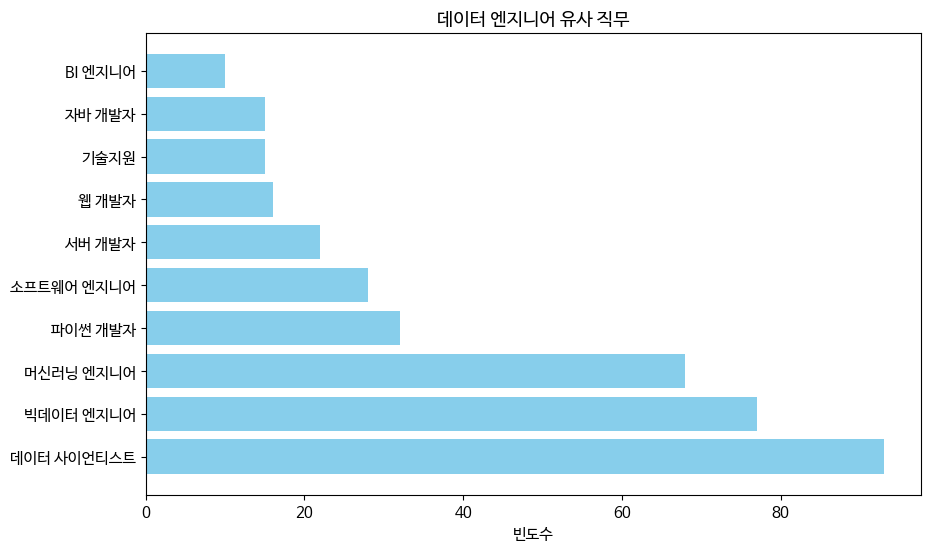

In [ ]:
exclude_job = '데이터 엔지니어'

similar_jobs_counter = Counter([job.strip() for jobs in df2['유사 직무'].str.split(',') for job in jobs if job != exclude_job])
top_similar_jobs = similar_jobs_counter.most_common(10)

plt.figure(figsize=(10, 6))
plt.barh([job[0] for job in top_similar_jobs], [job[1] for job in top_similar_jobs], color='skyblue')
plt.xlabel('빈도수')
plt.title(f'{exclude_job} 유사 직무')
plt.show()

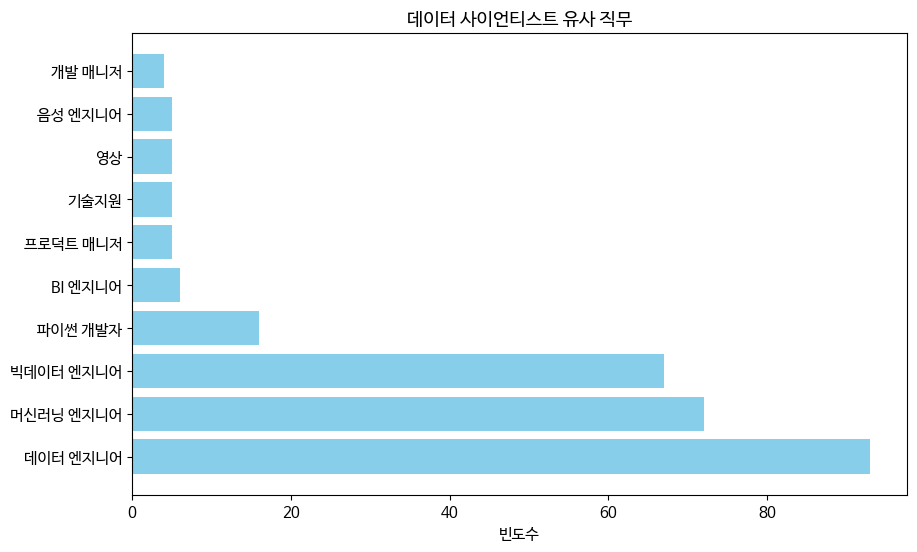

In [ ]:
exclude_job = '데이터 사이언티스트'

similar_jobs_counter = Counter([job.strip() for jobs in df3['유사 직무'].str.split(',') for job in jobs if job != exclude_job])
top_similar_jobs = similar_jobs_counter.most_common(10)

plt.figure(figsize=(10, 6))
plt.barh([job[0] for job in top_similar_jobs], [job[1] for job in top_similar_jobs], color='skyblue')
plt.xlabel('빈도수')
plt.title(f'{exclude_job} 유사 직무')
plt.show()

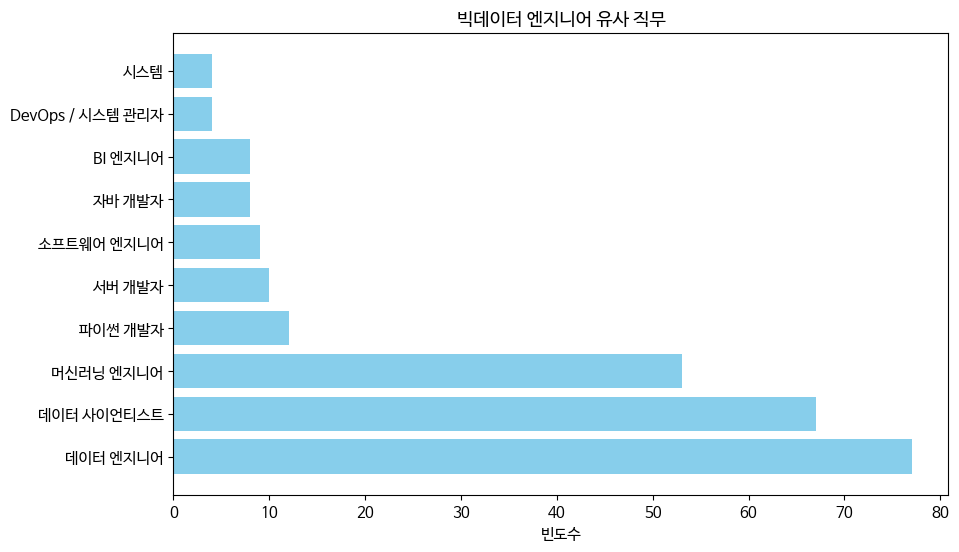

In [ ]:
exclude_job = '빅데이터 엔지니어'

similar_jobs_counter = Counter([job.strip() for jobs in df4['유사 직무'].str.split(',') for job in jobs if job != exclude_job])
top_similar_jobs = similar_jobs_counter.most_common(10)

plt.figure(figsize=(10, 6))
plt.barh([job[0] for job in top_similar_jobs], [job[1] for job in top_similar_jobs], color='skyblue')
plt.xlabel('빈도수')
plt.title(f'{exclude_job} 유사 직무')
plt.show()

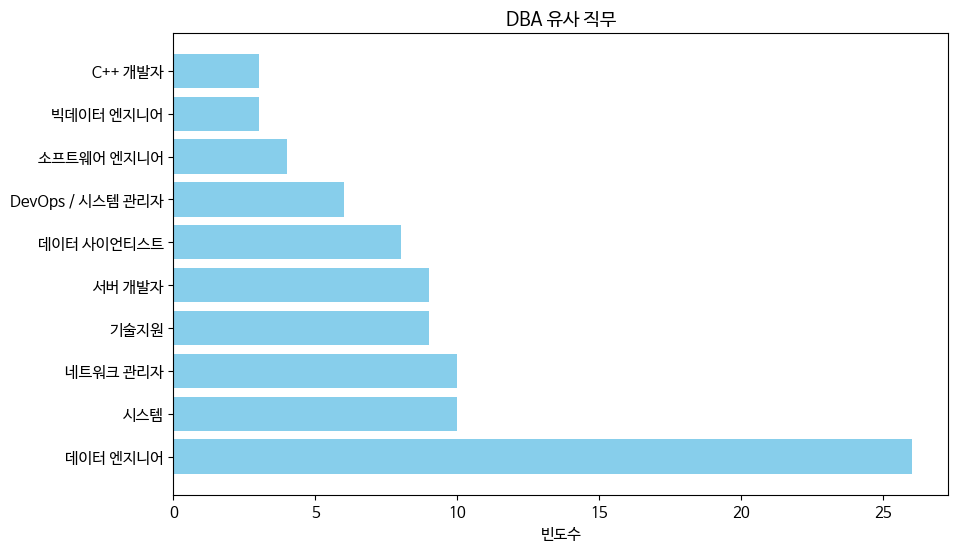

In [ ]:
exclude_job = 'DBA'

similar_jobs_counter = Counter([job.strip() for jobs in df5['유사 직무'].str.split(',') for job in jobs if job != exclude_job and job != ''])
top_similar_jobs = similar_jobs_counter.most_common(10)

plt.figure(figsize=(10, 6))
plt.barh([job[0] for job in top_similar_jobs], [job[1] for job in top_similar_jobs], color='skyblue')
plt.xlabel('빈도수')
plt.title(f'{exclude_job} 유사 직무')
plt.show()

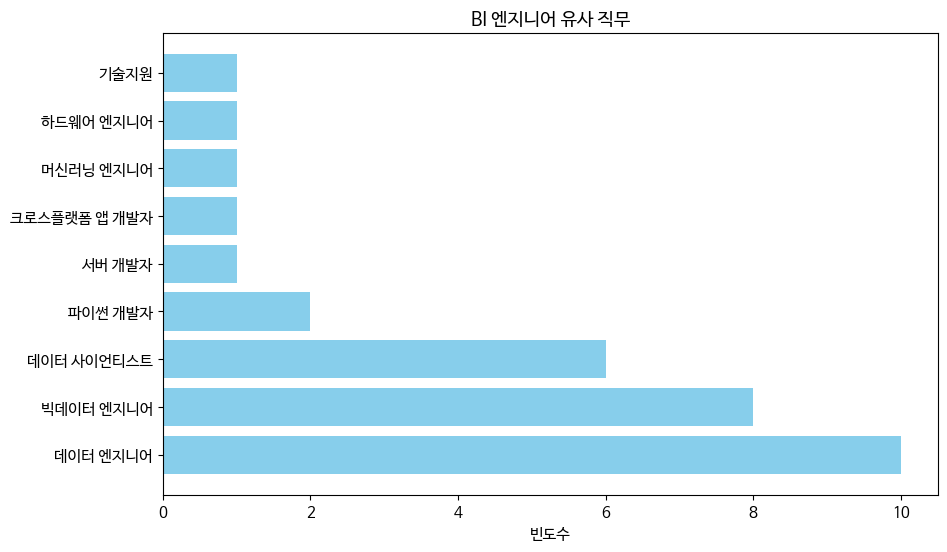

In [ ]:
exclude_job = 'BI 엔지니어'

similar_jobs_counter = Counter([job.strip() for jobs in df6['유사 직무'].str.split(',') for job in jobs if job != exclude_job])
top_similar_jobs = similar_jobs_counter.most_common(10)

plt.figure(figsize=(10, 6))
plt.barh([job[0] for job in top_similar_jobs], [job[1] for job in top_similar_jobs], color='skyblue')
plt.xlabel('빈도수')
plt.title(f'{exclude_job} 유사 직무')
plt.show()

### 업종

In [ ]:
df.업종.value_counts()

IT, 컨텐츠        904
전문, 과학기술        52
금융              37
제조              35
판매, 유통          31
교육              18
물류, 운송          17
기타 서비스업         16
보건, 사회복지        11
예술, 스포츠, 여가      8
사업지원             6
농림어업             4
게임               2
부동산              2
숙박, 음식점          2
Name: 업종, dtype: int64

<ipython-input-41-d27faf56a648>:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_counts_combined = top_industries.append(pd.Series({'기타': other_count}))


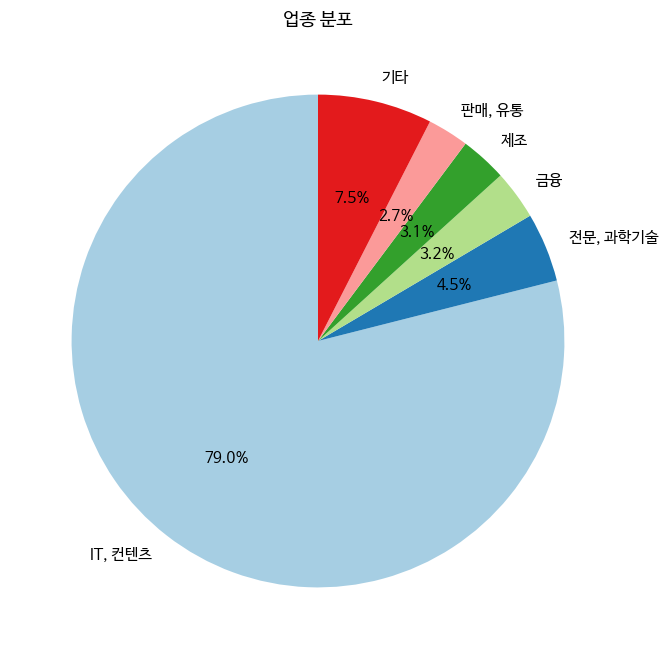

In [ ]:
industry_counts = df['업종'].value_counts()

top_industries = industry_counts.head(5)
other_count = industry_counts[5:].sum()
industry_counts_combined = top_industries.append(pd.Series({'기타': other_count}))

# 기본 글꼴 크기 설정
plt.rcParams['font.size'] = 11

plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(8, 8))
plt.pie(industry_counts_combined, labels=industry_counts_combined.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('업종 분포')
plt.show()

### 혜택 및 복지
- 혜택 및 복지의 문자열 길이가 길수록 혜택 및 복지가 좋다는 가정으로 그냥 한 번 해봄
- 감성 분석 해볼까 했는데, api 최대 길이 제한이 1000자라서 시도는 안해봄. 의미 없을 것 같기도하고..

In [ ]:
new_df = df.copy()
new_df['혜택 및 복지_num'] = num_df['혜택 및 복지_num']
new_df.head()

,공고명,직무,업종,유사 직무,회사명,회사소개,주요업무,자격요건,우대사항,혜택 및 복지,기술스택,기술스택_long,combined_token,combined,혜택 및 복지_num
0,"AI, ML Engineer 박사급",머신러닝 엔지니어,"IT, 컨텐츠","데이터 엔지니어,머신러닝 엔지니어",플리토,플리토는 유수의 글로벌 IT 기업들과 함께 언어 장벽 없는 세계를 만들어 가고 있는...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,"AI , ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분\n ML ...",모델을 직접 만들었거나 공개된 모델을 finetuning해서 성능을 향상시킨 경험이...,"상호 존중하는 문화\n 직급 없는 \님\ 호칭 및 경어 사용, 자율 복장 등\n ...",Github\n Android\n Firebase\n Kotlin\n Coroutine,Github 사용이 가능하신 분\n Android 활용이 가능하신 분\n Fireb...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다 ...,289
1,AI 컴파일러 개발자 (1년 이상),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,티에스엔랩,"실시간 AI, 실시간 통신 전문 기업 TSN Lab에서 네트워크 AI 개발자를 모십...",\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n,\n 웬만한 중견기업 못지 않은 복지 정책을 지원\n 임직원 연차 구분 없이 20일...,NaN,\n 웬만한 중견기업 못지 않은 복지 정책을 지원\n 임직원 연차 구분 없이 20일...,NaN,NaN,\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n\n\n 웬만한 중...,MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다 웬만한 중견기업 못지 않...,436
2,LLM 연구원 (자연어 처리),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),LLM 연구원 자연어 처리\n\n\n,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n,"경력 3년 이상 또는 관련 학과 석사 학위 소지자\n\nPyTorch, Tenso...","인공지능 관련 대회해커톤, 캐글, 그랜드챌린지 등의 출전 경험 및 입상\n\nM...",유연 근무제\n 자유 복장\n 최신 장비\n 수평적 조직\n 도서 구입비 지원\n ...,C#\n C\n C++\n WPF,C# 다룰 수 있으신 분\n C 활용 가능자\n C++ 활용 경험이 있으신 분\n ...,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n\n경...,LLM 모델 연구 및 고도화LLM 연구의 서비스화를 위한 개발 지원경력 3년 이상 ...,63
3,AI R&D 팀장,머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),AI RD 팀장\n\n\n,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,AI 관련학과 박사학위 소지자 또는 이에 준하는 경력 보유자\n\nLLM 관련 최신...,"AI 관련 Top tier 학회NeurIPS, CVPR, AAAI 등 논문 게재...",유연 근무제\n 자유 복장\n 최신 장비\n 수평적 조직\n 도서 구입비 지원\n ...,C#\n C\n C++\n WPF,C# 에 대한 이해\n C 사용 가능자\n C++ 에 대한 이해\n WPF 경험이 ...,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,sLLM 모델 연구개발 및 서비스 고도화 sLLM 기반의 서비스 모델 개발 및 튜닝...,63
4,소프트웨어 엔지니어,머신러닝 엔지니어,"IT, 컨텐츠","웹 개발자,머신러닝 엔지니어,소프트웨어 엔지니어","스타인펠드(Steinfeld,Inc.)",Steinfeldco는 치과 보철치료에 필요한 보철물을 더 효율적으로 제공하기 위해...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,python 또는 TypeScript 로 개발 경험 있으신분\n Open mind ...,성장하는 스타트업에 관심 있으신 분,경쟁력 있는 연봉\n 협의를 통해 충분히 경쟁력 있는 수준의 연봉을 제시합니다\...,Git\n Firebase\n Google Cloud Platform\n Pytor...,Git 에 대한 이해\n Firebase 사용 가능자\n Google Cloud P...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,AI 개발보철물 자동 디자인을 위한 AI 모델 개발보철물 자동 디자인 서비스 운영환...,209


In [ ]:
new_df.groupby('직무')['혜택 및 복지_num'].mean()

직무
BI 엔지니어       370.761905
DBA           335.179487
데이터 사이언티스트    422.858537
데이터 엔지니어      479.201220
머신러닝 엔지니어     415.682451
빅데이터 엔지니어     494.155844
Name: 혜택 및 복지_num, dtype: float64

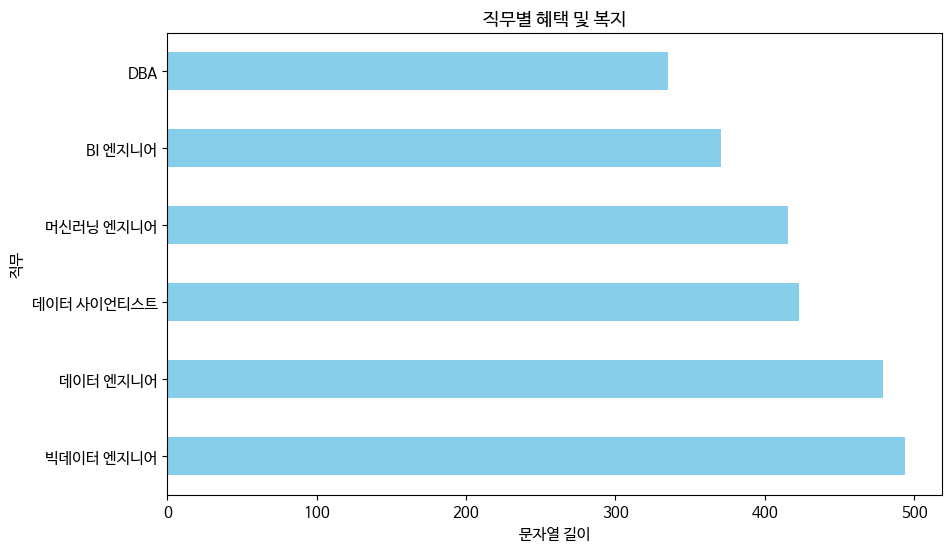

In [ ]:
mean = new_df.groupby('직무')['혜택 및 복지_num'].mean()

# 시각화 (horizontal bar plot)
plt.figure(figsize=(10, 6))
mean.sort_values(ascending = False).plot(kind='barh', color='skyblue')
plt.xlabel('문자열 길이')
plt.title('직무별 혜택 및 복지')
plt.show()

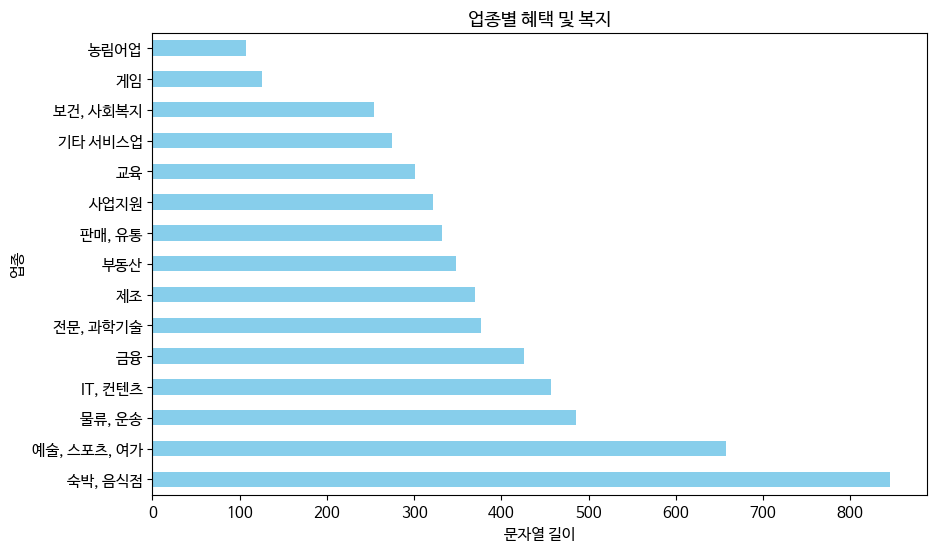

In [ ]:
mean = new_df.groupby('업종')['혜택 및 복지_num'].mean()

# 시각화 (horizontal bar plot)
plt.figure(figsize=(10, 6))
mean.sort_values(ascending = False).plot(kind='barh', color='skyblue')
plt.xlabel('문자열 길이')
plt.title('업종별 혜택 및 복지')
plt.show()

### 기술 스택

In [ ]:
skillsets = Counter([s for ss in df['기술스택'].fillna('').str.split(r'\\n ') for s in ss]).most_common()

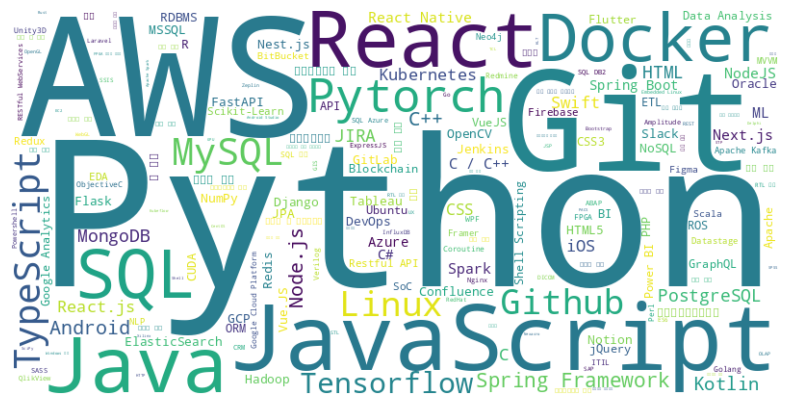

In [ ]:
wordcloud_data = {skill: count for skill, count in skillsets}
wordcloud = WordCloud(width=800, height=400, background_color='white',collocations=False).generate_from_frequencies(wordcloud_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 형태소 분석기 비교

In [ ]:
okt = Okt()
kkma = Kkma()
m = Mecab()
h = Hannanum()
komoran = Komoran()

In [ ]:
print('OKT 형태소 분석 :',okt.morphs("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('OKT 어구 추출 :',okt.phrases("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('OKT 품사 태깅 :',okt.pos("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('OKT 명사 추출 :',okt.nouns("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print(okt.tagset)

OKT 형태소 분석 : ['딥', '러닝', '과', 'SQL', '을', '활용', '한', '데이터', '추출', '및', '데이터', '분석', '이', '가능하신', '분']
OKT 어구 추출 : ['딥러닝', '딥러닝과 SQL', '활용', '데이터', '데이터 추출', '데이터 추출 및', '데이터 추출 및 데이터', '데이터 추출 및 데이터 분석', '가능하신 분', '러닝', 'SQL', '추출', '분석']
OKT 품사 태깅 : [('딥', 'Noun'), ('러닝', 'Noun'), ('과', 'Josa'), ('SQL', 'Alpha'), ('을', 'Josa'), ('활용', 'Noun'), ('한', 'Josa'), ('데이터', 'Noun'), ('추출', 'Noun'), ('및', 'Noun'), ('데이터', 'Noun'), ('분석', 'Noun'), ('이', 'Josa'), ('가능하신', 'Adjective'), ('분', 'Noun')]
OKT 명사 추출 : ['딥', '러닝', '활용', '데이터', '추출', '및', '데이터', '분석', '분']
{'Adjective': '형용사', 'Adverb': '부사', 'Alpha': '알파벳', 'Conjunction': '접속사', 'Determiner': '관형사', 'Eomi': '어미', 'Exclamation': '감탄사', 'Foreign': '외국어, 한자 및 기타기호', 'Hashtag': '트위터 해쉬태그', 'Josa': '조사', 'KoreanParticle': '(ex: ㅋㅋ)', 'Noun': '명사', 'Number': '숫자', 'PreEomi': '선어말어미', 'Punctuation': '구두점', 'ScreenName': '트위터 아이디', 'Suffix': '접미사', 'Unknown': '미등록어', 'Verb': '동사'}


In [ ]:
print('꼬꼬마 형태소 분석 :',kkma.morphs("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('꼬꼬마 품사 태깅 :',kkma.pos("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('꼬꼬마 명사 추출 :',kkma.nouns("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print(kkma.tagset)

꼬꼬마 형태소 분석 : ['딥', '러닝', '과', 'SQL', '을', '활용', '하', 'ㄴ', '데이터', '추출', '및', '데이터', '분석', '이', '가능', '하', '시', 'ㄴ', '분']
꼬꼬마 품사 태깅 : [('딥', 'NNG'), ('러닝', 'NNG'), ('과', 'JC'), ('SQL', 'OL'), ('을', 'JKO'), ('활용', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('데이터', 'NNG'), ('추출', 'NNG'), ('및', 'MAG'), ('데이터', 'NNG'), ('분석', 'NNG'), ('이', 'JKS'), ('가능', 'NNG'), ('하', 'XSV'), ('시', 'EPH'), ('ㄴ', 'ETD'), ('분', 'NNG')]
꼬꼬마 명사 추출 : ['딥', '딥러닝', '러닝', '활용', '데이터', '추출', '분석', '가능', '분']
{'EC': '연결 어미', 'ECD': '의존적 연결 어미', 'ECE': '대등 연결 어미', 'ECS': '보조적 연결 어미', 'EF': '종결 어미', 'EFA': '청유형 종결 어미', 'EFI': '감탄형 종결 어미', 'EFN': '평서형 종결 어미', 'EFO': '명령형 종결 어미', 'EFQ': '의문형 종결 어미', 'EFR': '존칭형 종결 어미', 'EP': '선어말 어미', 'EPH': '존칭 선어말 어미', 'EPP': '공손 선어말 어미', 'EPT': '시제 선어말 어미', 'ET': '전성 어미', 'ETD': '관형형 전성 어미', 'ETN': '명사형 전성 어미', 'IC': '감탄사', 'JC': '접속 조사', 'JK': '조사', 'JKC': '보격 조사', 'JKG': '관형격 조사', 'JKI': '호격 조사', 'JKM': '부사격 조사', 'JKO': '목적격 조사', 'JKQ': '인용격 조사', 'JKS': '주격 조사', 'JX': '보조사', 'MA': '부사', 'MA

In [ ]:
df.combined[0]

'기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다  LLM 학습 및 finetuning을 통해 내부적으로 필요한 LLM 개발을 진행합니다  AI   ML 개발 방향성에 대한 전략을 수립합니다  기업 고객에게 필요한 LLM 학습 데이터 구축 가이드라인 수립 및 사내 데이터 구축을 지원합니다AI   ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분  ML 프레임워크PyTorch  TensorFlow 등를 자신있게 다룰 수 있는 분모델을 직접 만들었거나 공개된 모델을 finetuning해서 성능을 향상시킨 경험이 있는 분  자신이 만든 모델을 실제 상용 서비스에 적용하고 운영한 경험이 있는 분  AWS나 Azure 등 클라우드 환경을 이용해 개발한 경험이 있는 분  Github에 공개 가능한 ML 프로젝트가 있는 분'

In [ ]:
print('꼬꼬마 문장 추출 :',kkma.sentences(df.combined[0]))

꼬꼬마 문장 추출 : ['기존 플 리 토 번역기에 신규 언어 쌍 추가 및 플 리 토 번역기 성능 고도화를 담당합니다', 'LLM 학습 및 finetuning을 통해 내부적으로 필요한 LLM 개발을 진행합니다', 'AI ML 개발 방향성에 대한 전략을 수립합니다', '기업 고객에게 필요한 LLM 학습 데이터 구축 가이드라인 수립 및 사내 데이터 구축을 지원합니다', 'AI ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분 ML 프레임 워크 PyTorch TensorFlow 등를 자신 있게 다룰 수 있는 분 모델을 직접 만들었거나 공개된 모델을 finetuning 해서 성능을 향상시킨 경험이 있는 분 자신이 만든 모델을 실제 상용 서비스에 적용하고 운영한 경험이 있는 분 AWS 나 Azure 등 클라우드 환경을 이용해 개발한 경험이 있는 분 Github에 공개 가능한 ML 프로젝트가 있는 분']


In [ ]:
print('mecab 형태소 분석 :',m.morphs("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('mecab 품사 태깅 :',m.pos("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('mecab 명사 추출 :',m.nouns("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print(m.tagset)

mecab 형태소 분석 : ['딥', '러닝', '과', 'SQL', '을', '활용', '한', '데이터', '추출', '및', '데이터', '분석', '이', '가능', '하', '신', '분']
mecab 품사 태깅 : [('딥', 'NNG'), ('러닝', 'NNG'), ('과', 'JC'), ('SQL', 'SL'), ('을', 'JKO'), ('활용', 'NNG'), ('한', 'XSV+ETM'), ('데이터', 'NNG'), ('추출', 'NNG'), ('및', 'MAJ'), ('데이터', 'NNG'), ('분석', 'NNG'), ('이', 'JKS'), ('가능', 'NNG'), ('하', 'XSA'), ('신', 'EP+ETM'), ('분', 'NNB')]
mecab 명사 추출 : ['딥', '러닝', '활용', '데이터', '추출', '데이터', '분석', '가능', '분']
{'EC': '연결 어미', 'EF': '종결 어미', 'EP': '선어말어미', 'ETM': '관형형 전성 어미', 'ETN': '명사형 전성 어미', 'IC': '감탄사', 'JC': '접속 조사', 'JKB': '부사격 조사', 'JKC': '보격 조사', 'JKG': '관형격 조사', 'JKO': '목적격 조사', 'JKQ': '인용격 조사', 'JKS': '주격 조사', 'JKV': '호격 조사', 'JX': '보조사', 'MAG': '일반 부사', 'MAJ': '접속 부사', 'MM': '관형사', 'NNB': '의존 명사', 'NNBC': '단위를 나타내는 명사', 'NNG': '일반 명사', 'NNP': '고유 명사', 'NP': '대명사', 'NR': '수사', 'SC': '구분자 , · / :', 'SE': '줄임표 …', 'SF': '마침표, 물음표, 느낌표', 'SH': '한자', 'SL': '외국어', 'SN': '숫자', 'SSC': '닫는 괄호 ), ]', 'SSO': '여는 괄호 (, [', 'SY': '기타 기호', 'VA': '형용사', 

In [ ]:
## 딥러닝을 명사로 판단

print('Hannanum 형태소 분석 :',h.morphs("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('Hannanum 품사 태깅 :',h.pos("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('Hannanum 명사 추출 :',h.nouns("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print(h.tagset)

Hannanum 형태소 분석 : ['딥러닝', '과', 'SQL', '을', '활용', '하', 'ㄴ', '데이터', '추출', '및', '데이터', '분석', '이', '가능', '하', '시ㄴ', '분']
Hannanum 품사 태깅 : [('딥러닝', 'N'), ('과', 'J'), ('SQL', 'F'), ('을', 'J'), ('활용', 'N'), ('하', 'X'), ('ㄴ', 'E'), ('데이터', 'N'), ('추출', 'N'), ('및', 'M'), ('데이터', 'N'), ('분석', 'N'), ('이', 'J'), ('가능', 'N'), ('하', 'X'), ('시ㄴ', 'E'), ('분', 'N')]
Hannanum 명사 추출 : ['딥러닝', '활용', '데이터', '추출', '데이터', '분석', '가능', '분']
{'E': '어미', 'EC': '연결 어미', 'EF': '종결 어미', 'EP': '선어말어미', 'ET': '전성 어미', 'F': '외국어', 'I': '독립언', 'II': '감탄사', 'J': '관계언', 'JC': '격조사', 'JP': '서술격 조사', 'JX': '보조사', 'M': '수식언', 'MA': '부사', 'MM': '관형사', 'N': '체언', 'NB': '의존명사', 'NC': '보통명사', 'NN': '수사', 'NP': '대명사', 'NQ': '고유명사', 'P': '용언', 'PA': '형용사', 'PV': '동사', 'PX': '보조 용언', 'S': '기호', 'X': '접사', 'XP': '접두사', 'XS': '접미사'}


In [ ]:
print('Komoran 형태소 분석 :',komoran.morphs("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('Komoran 품사 태깅 :',komoran.pos("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print('Komoran 명사 추출 :',komoran.nouns("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분"))
print(komoran.tagset)

Komoran 형태소 분석 : ['딥러닝과', 'SQL', '을', '활용', '하', 'ㄴ', '데이터', '추출', '및', '데이터', '분석', '이', '가능', '하', '시', 'ㄴ', '분']
Komoran 품사 태깅 : [('딥러닝과', 'NA'), ('SQL', 'SL'), ('을', 'ETM'), ('활용', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETM'), ('데이터', 'NNG'), ('추출', 'NNP'), ('및', 'MAJ'), ('데이터', 'NNG'), ('분석', 'NNG'), ('이', 'JKS'), ('가능', 'XR'), ('하', 'XSA'), ('시', 'EP'), ('ㄴ', 'ETM'), ('분', 'NNB')]
Komoran 명사 추출 : ['활용', '데이터', '추출', '데이터', '분석', '분']
{'EC': '연결 어미', 'EF': '종결 어미', 'EP': '선어말어미', 'ETM': '관형형 전성 어미', 'ETN': '명사형 전성 어미', 'IC': '감탄사', 'JC': '접속 조사', 'JKB': '부사격 조사', 'JKC': '보격 조사', 'JKG': '관형격 조사', 'JKO': '목적격 조사', 'JKQ': '인용격 조사', 'JKS': '주격 조사', 'JKV': '호격 조사', 'JX': '보조사', 'MAG': '일반 부사', 'MAJ': '접속 부사', 'MM': '관형사', 'NA': '분석불능범주', 'NF': '명사추정범주', 'NNB': '의존 명사', 'NNG': '일반 명사', 'NNP': '고유 명사', 'NP': '대명사', 'NR': '수사', 'NV': '용언추정범주', 'SE': '줄임표', 'SF': '마침표, 물음표, 느낌표', 'SH': '한자', 'SL': '외국어', 'SN': '숫자', 'SO': '붙임표(물결,숨김,빠짐)', 'SP': '쉼표,가운뎃점,콜론,빗금', 'SS': '따옴표,괄호표,줄표', 'SW': '기타기호 (논리수학기

In [ ]:
print('OKT 형태소 분석 :',okt.morphs("딥러닝과 SQL에 익숙하신 분"))
print('OKT 명사 추출 :',okt.nouns("딥러닝과 SQL에 익숙하신 분"))

OKT 형태소 분석 : ['딥', '러닝', '과', 'SQL', '에', '익숙하신', '분']
OKT 명사 추출 : ['딥', '러닝', '분']


In [ ]:
print('꼬꼬마 형태소 분석 :',kkma.morphs("딥러닝과 SQL에 익숙하신 분"))
print('꼬꼬마 명사 추출 :',kkma.nouns("딥러닝과 SQL에 익숙하신 분"))

꼬꼬마 형태소 분석 : ['딥', '러닝', '과', 'SQL', '에', '익숙', '하', '시', 'ㄴ', '분']
꼬꼬마 명사 추출 : ['딥', '딥러닝', '러닝', '분']


In [ ]:
print('mecab 형태소 분석 :',m.morphs("딥러닝과 SQL에 익숙하신 분"))
print('mecab 명사 추출 :',m.nouns("딥러닝과 SQL에 익숙하신 분"))

mecab 형태소 분석 : ['딥', '러닝', '과', 'SQL', '에', '익숙', '하', '신', '분']
mecab 명사 추출 : ['딥', '러닝', '분']


In [ ]:
print('Hannanum 형태소 분석 :',h.morphs("딥러닝과 SQL에 익숙하신 분"))
print('Hannanum 명사 추출 :',h.nouns("딥러닝과 SQL에 익숙하신 분"))

Hannanum 형태소 분석 : ['딥러닝', '과', 'SQL', '에', '익숙', '하', '시ㄴ', '분']
Hannanum 명사 추출 : ['딥러닝', '익숙', '분']


In [ ]:
print('Komoran 형태소 분석 :',komoran.morphs("딥러닝과 SQL에 익숙하신 분"))
print('Komoran 명사 추출 :',komoran.nouns("딥러닝과 SQL에 익숙하신 분"))

Komoran 형태소 분석 : ['딥러닝과', 'SQL', '에', '익숙', '하', '시', 'ㄴ', '분']
Komoran 명사 추출 : ['분']


## soynlp 형태소 분석, 명사 추출

In [ ]:
# WordExtractor의 parameter
# def __init__(max_left_length=10,
#            max_right_length=6,
#            min_frequency=5,
#            verbose_points=100000,
#            min_cohesion_forward=0.1,
#            min_cohesion_backward=0.0,
#            max_droprate_cohesion=0.95,
#            max_droprate_leftside_frequency=0.95,
#            min_left_branching_entropy=0.0,
#            min_right_branching_entropy=0.0,
#            min_left_accessor_variety=0,
#            min_right_accessor_variety=0,
#            remove_subwords=True)


# 형태소에 해당하는 단어를 분리하는 학습 수행
from soynlp.word import WordExtractor

# 다른 파라미터는 그냥 두고, min_frequency만 1로 설정.
word_extractor = WordExtractor(min_frequency=1)

# 단어 토큰화를 위해 df['combined'] 학습
word_extractor.train(df['combined'].astype(str))

# cohesion, branching entropy, accessor variety score 계산
# cohension : 조건부확률을 통해 한글자씩 예측. cohension 값이 높은 위치가 하나의 단어를 이루고 있을 가능성이 큼.
# branching entropy : 확률분포의 엔트로피를 통  해서 계산
# accessor variety : 확률분포 없이, 다음 글자로 등장할 수 있는 경우의 수 계산
word_score = word_extractor.extract()

training was done. used memory 0.908 Gb
all cohesion probabilities was computed. # words = 52418
all branching entropies was computed # words = 43153
all accessor variety was computed # words = 43153


In [ ]:
# 총 단어 후보 개수 확인
len(word_score)

31240

In [ ]:
# soynlp의 토큰화 방식.

# L-토큰화
# 한국어의 경우 공백(띄어쓰기)으로 분리된 하나의 문자열은 ‘L 토큰 + R 토큰; 구조인 경우가 많음
# 왼쪽에 오는 L 토큰은 체언(명사, 대명사)이나 동사, 형용사 등이고 오른쪽에 오는 R 토큰은 조사, 동사, 형용사 등이다.
# 여러가지 길이의 L 토큰의 점수를 비교하여 가장 점수가 높 L단어를 찾는 방법
from soynlp.tokenizer import LTokenizer

# 최대점수토큰화
# 띄어쓰기가 되어 있지 않는 긴 문자열에서 가능한 모든 종류의 부분문자열을 만들어서 가장 점수가 높은 것을 하나의 토큰으로
# 우리는 띄어쓰기가 되어있는 텍스트니까 사용하지 않을 예정
from soynlp.tokenizer import MaxScoreTokenizer

# 규칙기반토큰화
# 우리가 사용하기에 적절치않음.
from soynlp.tokenizer import RegexTokenizer

In [ ]:
# cohesion_forward 기준
scores = {word:score.cohesion_forward for word, score in word_score.items()}
l_tokenizer = LTokenizer(scores=scores)

l_tokenizer.tokenize("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분", flatten=True)
# flatten = False : ('딥러닝','과') , ('SQL','을') ...

['딥러닝',
 '과',
 'SQL',
 '을',
 '활용',
 '한',
 '데이',
 '터',
 '추출',
 '및',
 '데이',
 '터',
 '분석',
 '이',
 '가능',
 '하신',
 '분']

In [ ]:
# cohesion_backward 기준
scores = {word:score.cohesion_backward for word, score in word_score.items()}
l_tokenizer = LTokenizer(scores=scores)

l_tokenizer.tokenize("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분", flatten=True)

['딥러닝',
 '과',
 'SQL',
 '을',
 '활용',
 '한',
 '데이터',
 '추출',
 '및',
 '데이터',
 '분석',
 '이',
 '가능하신',
 '분']

In [ ]:
# left_branching_entropy 기준
scores = {word:score.left_branching_entropy for word, score in word_score.items()}
l_tokenizer = LTokenizer(scores=scores)

l_tokenizer.tokenize("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분", flatten=True)

['딥러닝',
 '과',
 'SQL',
 '을',
 '활용',
 '한',
 '데이터',
 '추출',
 '및',
 '데이터',
 '분석',
 '이',
 '가능',
 '하신',
 '분']

In [ ]:
# right_branching_entropy 기준

scores = {word:score.right_branching_entropy for word, score in word_score.items()}
l_tokenizer = LTokenizer(scores=scores)

l_tokenizer.tokenize("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분", flatten=True)

['딥러닝',
 '과',
 'SQL',
 '을',
 '활용한',
 '데이터',
 '추출',
 '및',
 '데이터',
 '분석',
 '이',
 '가능',
 '하신',
 '분']

In [ ]:
# left_accessor_variety 기준
scores = {word:score.left_accessor_variety for word, score in word_score.items()}
l_tokenizer = LTokenizer(scores=scores)

l_tokenizer.tokenize("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분", flatten=True)

['딥러닝',
 '과',
 'SQL',
 '을',
 '활용',
 '한',
 '데이터',
 '추출',
 '및',
 '데이터',
 '분석',
 '이',
 '가능',
 '하신',
 '분']

In [ ]:
# right_accessor_variety 기준
scores = {word:score.right_accessor_variety for word, score in word_score.items()}
l_tokenizer = LTokenizer(scores=scores)

l_tokenizer.tokenize("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분", flatten=True)

['딥러닝',
 '과',
 'SQL',
 '을',
 '활용한',
 '데이터',
 '추출',
 '및',
 '데이터',
 '분석',
 '이',
 '가능',
 '하신',
 '분']

In [ ]:
# leftside_frequency 기준
scores = {word:score.leftside_frequency for word, score in word_score.items()}
l_tokenizer = LTokenizer(scores=scores)

l_tokenizer.tokenize("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분", flatten=True)

['딥러닝',
 '과',
 'SQ',
 'L을',
 '활용',
 '한',
 '데이',
 '터',
 '추출',
 '및',
 '데이',
 '터',
 '분석',
 '이',
 '가능',
 '하신',
 '분']

In [ ]:
# rightside_frequency 기준
scores = {word:score.rightside_frequency for word, score in word_score.items()}
l_tokenizer = LTokenizer(scores=scores)

l_tokenizer.tokenize("딥러닝과 SQL을 활용한 데이터 추출 및 데이터 분석이 가능하신 분", flatten=True)

['딥러닝',
 '과',
 'SQL',
 '을',
 '활용',
 '한',
 '데이터',
 '추출',
 '및',
 '데이터',
 '분석',
 '이',
 '가능하신',
 '분']

In [ ]:
# v2가 더 좋다고는 하지만, 명사 판별 기능을 지원하지 않아서 사용 안함. 그런데 결과 보면 더 좋은건지도 사실 잘 모르겠음.
from soynlp.noun import LRNounExtractor_v2
from soynlp.noun import LRNounExtractor

# 명사 추출을 위해 df['combined'] 학습
noun_extractor = LRNounExtractor()
nouns = noun_extractor.train_extract(df['combined'].astype(str))

[Noun Extractor] used default noun predictor; Sejong corpus predictor
[Noun Extractor] used noun_predictor_sejong
[Noun Extractor] All 2398 r features was loaded
[Noun Extractor] scanning was done (L,R) has (5875, 3597) tokens
[Noun Extractor] building L-R graph was done
[Noun Extractor] 934 nouns are extracted


In [ ]:
# ex) '통계': NounScore(frequency=137, score=1.0)
# 추출한 명사의 수
len(nouns)

934

In [ ]:
# 기존 konlpy 형태소분석기에서는 외국어로 판단됐으나, noun_extractor 학습 후에는 SQL을 명사라고 판단
noun_extractor.is_noun('SQL')

True

In [ ]:
# 학습 데이터에 존재하지 않는 건 명사라고 인식 못하는 듯
# 토큰화 과정에서 별도의 외부 데이터 혹은 사전이 필요 없는 비지도 학습이라는 장점이 있지만, 그만큼 학습데이터에 민감하게 작용함.
noun_extractor.is_noun('화학')

False

In [ ]:
noun_extractor.is_noun('사과')

False

In [ ]:
noun_extractor.is_noun('통계')

True

In [ ]:
noun_extractor.is_noun('sql')

False

In [ ]:
noun_extractor.is_noun('SQL')

True

In [ ]:
noun_extractor.is_noun('딥러닝')

True

In [ ]:
noun_extractor.is_noun('finetuning')

True

In [ ]:
# 명사추출기의 score와 cohesion score를 함께 이용해서 토큰화 하기

cohesion_score = {word:score.cohesion_forward for word, score in word_score.items()}
noun_scores = {noun:score.score for noun, score in nouns.items()}

combined_scores = {noun:score + cohesion_score.get(noun, 0)
    for noun, score in noun_scores.items()}

combined_scores.update(
    {subword:cohesion for subword, cohesion in cohesion_score.items()
    if not (subword in combined_scores)}
)

tokenizer = LTokenizer(scores=combined_scores)

In [ ]:
# 형태소 토큰화 한뒤, token 컬럼에 결과 저장.
train_list=list(df.combined)
token_result = []
for i in range(len(train_list)):
    token = []
    tok = tokenizer.tokenize(str(train_list[i]))
    for j in tok:
        if j not in stop:
            token.append(j)
    token_result.append(token)

df['token'] = token_result
df.head()

,공고명,직무,업종,유사 직무,회사명,회사소개,주요업무,자격요건,우대사항,혜택 및 복지,기술스택,기술스택_long,combined_token,combined,token
0,"AI, ML Engineer 박사급",머신러닝 엔지니어,"IT, 컨텐츠","데이터 엔지니어,머신러닝 엔지니어",플리토,플리토는 유수의 글로벌 IT 기업들과 함께 언어 장벽 없는 세계를 만들어 가고 있는...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,"AI , ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분\n ML ...",모델을 직접 만들었거나 공개된 모델을 finetuning해서 성능을 향상시킨 경험이...,"- 상호 존중하는 문화\n : 직급 없는 \""님\"" 호칭 및 경어 사용, 자율 ...",Github\n Android\n Firebase\n Kotlin\n Coroutine,Github 에 대한 이해도가 있으신 분\n Android 사용 경험이 있으신 분\...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다 ...,"[플리토, 번역, 기에, 언어, 쌍, 및, 플리토, 번역, 기, 성능, 고도화, 를..."
1,AI 컴파일러 개발자 (1년 이상),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,티에스엔랩,"실시간 AI, 실시간 통신 전문 기업 TSN Lab에서 네트워크 AI 개발자를 모십...",\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n,\n 웬만한 중견기업 못지 않은 복지 정책을 지원\n 임직원 연차 구분 없이 20일...,NaN,[연봉은 어떻게 되나요?]\n• 경력자의 경우 기존의 경력과 동일한 분야인 경우 기...,NaN,NaN,\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n\n\n 웬만한 중...,MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다 웬만한 중견기업 못지 않...,"[ML, IR, 의, AI, 컴파일러, 프로젝트, 에, 참여, 웬만한, 중견기업, ..."
2,LLM 연구원 (자연어 처리),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),LLM 연구원 자연어 처리\n\n\n,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n,"경력 3년 이상 또는 관련 학과 석사 학위 소지자\n\nPyTorch, Tenso...","인공지능 관련 대회해커톤, 캐글, 그랜드챌린지 등의 출전 경험 및 입상\n\nM...",1. 유연 근무제\n2. 자유 복장\n3. 최신 장비\n4. 수평적 조직\n5. 도...,C#\n C\n C++\n WPF,C# 사용 가능자\n C 사용 가능자\n C++ 활용 경험이 있으신 분\n WPF ...,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n\n경...,LLM 모델 연구 및 고도화LLM 연구의 서비스화를 위한 개발 지원경력 3년 이상 ...,"[LLM, 모델, 연구, 및, 고도화, LLM, 연구, 의, 화를, 학과, 석사, ..."
3,AI R&D 팀장,머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),AI RD 팀장\n\n\n,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,AI 관련학과 박사학위 소지자 또는 이에 준하는 경력 보유자\n\nLLM 관련 최신...,"AI 관련 Top tier 학회NeurIPS, CVPR, AAAI 등 논문 게재...",1. 유연 근무제\n2. 자유 복장\n3. 최신 장비\n4. 수평적 조직\n5. 도...,C#\n C\n C++\n WPF,C# 다룰 수 있으신 분\n C 활용 경험이 있으신 분\n C++ 사용 가능자\n ...,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,sLLM 모델 연구개발 및 서비스 고도화 sLLM 기반의 서비스 모델 개발 및 튜닝...,"[sLLM, 모델, 연구, 및, 고도화, sLLM, 의, 모델, 및, 튜닝, 리딩,..."
4,소프트웨어 엔지니어,머신러닝 엔지니어,"IT, 컨텐츠","웹 개발자,머신러닝 엔지니어,소프트웨어 엔지니어","스타인펠드(Steinfeld,Inc.)",Steinfeldco는 치과 보철치료에 필요한 보철물을 더 효율적으로 제공하기 위해...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,python 또는 TypeScript 로 개발 경험 있으신분\n Open mind ...,성장하는 스타트업에 관심 있으신 분,• 경쟁력 있는 연봉\n - 협의를 통해 충분히 경쟁력 있는 수준의 연봉을 제...,Git\n Firebase\n Google Cloud Platform\n Pytor...,Git 경험이 있으신 분\n Firebase 에 대한 이해도가 있으신 분\n Goo...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,AI 개발보철물 자동 디자인을 위한 AI 모델 개발보철물 자동 디자인 서비스 운영환...,"[AI, 보철물, 자동, 디자인, AI, 모델, 보철물, 자동, 디자인, 운영, 환..."


In [ ]:
# 토큰화 한뒤, 토큰마다 명사 판별 진행하여 명사 추출하기. nouns 컬럼에 결과 저장.

train_list=list(df.combined)
num_result = []
for i in range(len(train_list)):
    num = []
    tok = tokenizer.tokenize(str(train_list[i]))
    for j in tok:
        if noun_extractor.is_noun(j) and j not in stop:
            num.append(j)
    num_result.append(num)

df['nouns'] = num_result
df.head()

,공고명,직무,업종,유사 직무,회사명,회사소개,주요업무,자격요건,우대사항,혜택 및 복지,기술스택,기술스택_long,combined_token,combined,token,nouns
0,"AI, ML Engineer 박사급",머신러닝 엔지니어,"IT, 컨텐츠","데이터 엔지니어,머신러닝 엔지니어",플리토,플리토는 유수의 글로벌 IT 기업들과 함께 언어 장벽 없는 세계를 만들어 가고 있는...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,"AI , ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분\n ML ...",모델을 직접 만들었거나 공개된 모델을 finetuning해서 성능을 향상시킨 경험이...,"- 상호 존중하는 문화\n : 직급 없는 \""님\"" 호칭 및 경어 사용, 자율 ...",Github\n Android\n Firebase\n Kotlin\n Coroutine,Github 에 대한 이해도가 있으신 분\n Android 사용 경험이 있으신 분\...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다 ...,"[플리토, 번역, 기에, 언어, 쌍, 및, 플리토, 번역, 기, 성능, 고도화, 를...","[언어, 성능, 고도화, LLM, 학습, finetuning, LLM, AI, ML..."
1,AI 컴파일러 개발자 (1년 이상),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,티에스엔랩,"실시간 AI, 실시간 통신 전문 기업 TSN Lab에서 네트워크 AI 개발자를 모십...",\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n,\n 웬만한 중견기업 못지 않은 복지 정책을 지원\n 임직원 연차 구분 없이 20일...,NaN,[연봉은 어떻게 되나요?]\n• 경력자의 경우 기존의 경력과 동일한 분야인 경우 기...,NaN,NaN,\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n\n\n 웬만한 중...,MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다 웬만한 중견기업 못지 않...,"[ML, IR, 의, AI, 컴파일러, 프로젝트, 에, 참여, 웬만한, 중견기업, ...","[ML, AI, 컴파일러, 프로젝트, 참여, 정직, 원, 학사, 석사, 박사, 이사..."
2,LLM 연구원 (자연어 처리),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),LLM 연구원 자연어 처리\n\n\n,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n,"경력 3년 이상 또는 관련 학과 석사 학위 소지자\n\nPyTorch, Tenso...","인공지능 관련 대회해커톤, 캐글, 그랜드챌린지 등의 출전 경험 및 입상\n\nM...",1. 유연 근무제\n2. 자유 복장\n3. 최신 장비\n4. 수평적 조직\n5. 도...,C#\n C\n C++\n WPF,C# 사용 가능자\n C 사용 가능자\n C++ 활용 경험이 있으신 분\n WPF ...,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n\n경...,LLM 모델 연구 및 고도화LLM 연구의 서비스화를 위한 개발 지원경력 3년 이상 ...,"[LLM, 모델, 연구, 및, 고도화, LLM, 연구, 의, 화를, 학과, 석사, ...","[LLM, 모델, 연구, 고도화, LLM, 연구, 학과, 석사, 학위, PyTorc..."
3,AI R&D 팀장,머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),AI RD 팀장\n\n\n,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,AI 관련학과 박사학위 소지자 또는 이에 준하는 경력 보유자\n\nLLM 관련 최신...,"AI 관련 Top tier 학회NeurIPS, CVPR, AAAI 등 논문 게재...",1. 유연 근무제\n2. 자유 복장\n3. 최신 장비\n4. 수평적 조직\n5. 도...,C#\n C\n C++\n WPF,C# 다룰 수 있으신 분\n C 활용 경험이 있으신 분\n C++ 사용 가능자\n ...,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,sLLM 모델 연구개발 및 서비스 고도화 sLLM 기반의 서비스 모델 개발 및 튜닝...,"[sLLM, 모델, 연구, 및, 고도화, sLLM, 의, 모델, 및, 튜닝, 리딩,...","[모델, 연구, 고도화, 모델, 튜닝, 리딩, 프로젝트, 관리, 협업, 리딩, LL..."
4,소프트웨어 엔지니어,머신러닝 엔지니어,"IT, 컨텐츠","웹 개발자,머신러닝 엔지니어,소프트웨어 엔지니어","스타인펠드(Steinfeld,Inc.)",Steinfeldco는 치과 보철치료에 필요한 보철물을 더 효율적으로 제공하기 위해...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,python 또는 TypeScript 로 개발 경험 있으신분\n Open mind ...,성장하는 스타트업에 관심 있으신 분,• 경쟁력 있는 연봉\n - 협의를 통해 충분히 경쟁력 있는 수준의 연봉을 제...,Git\n Firebase\n Google Cloud Platform\n Pytor...,Git 경험이 있으신 분\n Firebase 에 대한 이해도가 있으신 분\n Goo...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,AI 개발보철물 자동 디자인을 위한 AI 모델 개발보철물 자동 디자인 서비스 운영환...,"[AI, 보철물, 자동, 디자인, AI, 모델, 보철물, 자동, 디자인, 운영, 환...","[AI, 자동, 디자인, AI, 모델, 자동, 디자인, 운영, 데이터, 관리, Pr..."


In [ ]:
# 줄바꿈을 기준으로 문장토큰화 + 불용어처리
df['sentence'] = df['combined_token'].str.split(r'\\n').apply(lambda ss: [s.strip('\ ') for s in ss if len(s) > 1 and s not in stop])
df.head()

,공고명,직무,업종,유사 직무,회사명,회사소개,주요업무,자격요건,우대사항,혜택 및 복지,기술스택,기술스택_long,combined_token,combined,token,nouns,sentence
0,"AI, ML Engineer 박사급",머신러닝 엔지니어,"IT, 컨텐츠","데이터 엔지니어,머신러닝 엔지니어",플리토,플리토는 유수의 글로벌 IT 기업들과 함께 언어 장벽 없는 세계를 만들어 가고 있는...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,"AI , ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분\n ML ...",모델을 직접 만들었거나 공개된 모델을 finetuning해서 성능을 향상시킨 경험이...,"- 상호 존중하는 문화\n : 직급 없는 \""님\"" 호칭 및 경어 사용, 자율 ...",Github\n Android\n Firebase\n Kotlin\n Coroutine,Github 에 대한 이해도가 있으신 분\n Android 사용 경험이 있으신 분\...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다\...,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다 ...,"[플리토, 번역, 기에, 언어, 쌍, 및, 플리토, 번역, 기, 성능, 고도화, 를...","[언어, 성능, 고도화, LLM, 학습, finetuning, LLM, AI, ML...",[기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다...
1,AI 컴파일러 개발자 (1년 이상),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,티에스엔랩,"실시간 AI, 실시간 통신 전문 기업 TSN Lab에서 네트워크 AI 개발자를 모십...",\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n,\n 웬만한 중견기업 못지 않은 복지 정책을 지원\n 임직원 연차 구분 없이 20일...,NaN,[연봉은 어떻게 되나요?]\n• 경력자의 경우 기존의 경력과 동일한 분야인 경우 기...,NaN,NaN,\n MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다\n\n\n 웬만한 중...,MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다 웬만한 중견기업 못지 않...,"[ML, IR, 의, AI, 컴파일러, 프로젝트, 에, 참여, 웬만한, 중견기업, ...","[ML, AI, 컴파일러, 프로젝트, 참여, 정직, 원, 학사, 석사, 박사, 이사...","[MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다, 웬만한 중견기업 못지 ..."
2,LLM 연구원 (자연어 처리),머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),LLM 연구원 자연어 처리\n\n\n,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n,"경력 3년 이상 또는 관련 학과 석사 학위 소지자\n\nPyTorch, Tenso...","인공지능 관련 대회해커톤, 캐글, 그랜드챌린지 등의 출전 경험 및 입상\n\nM...",1. 유연 근무제\n2. 자유 복장\n3. 최신 장비\n4. 수평적 조직\n5. 도...,C#\n C\n C++\n WPF,C# 사용 가능자\n C 사용 가능자\n C++ 활용 경험이 있으신 분\n WPF ...,LLM 모델 연구 및 고도화\n\nLLM 연구의 서비스화를 위한 개발 지원\n\n경...,LLM 모델 연구 및 고도화LLM 연구의 서비스화를 위한 개발 지원경력 3년 이상 ...,"[LLM, 모델, 연구, 및, 고도화, LLM, 연구, 의, 화를, 학과, 석사, ...","[LLM, 모델, 연구, 고도화, LLM, 연구, 학과, 석사, 학위, PyTorc...","[LLM 모델 연구 및 고도화, LLM 연구의 서비스화를 위한 개발 지원, 경력 3..."
3,AI R&D 팀장,머신러닝 엔지니어,"IT, 컨텐츠",머신러닝 엔지니어,딥노이드(Deepnoid),AI RD 팀장\n\n\n,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,AI 관련학과 박사학위 소지자 또는 이에 준하는 경력 보유자\n\nLLM 관련 최신...,"AI 관련 Top tier 학회NeurIPS, CVPR, AAAI 등 논문 게재...",1. 유연 근무제\n2. 자유 복장\n3. 최신 장비\n4. 수평적 조직\n5. 도...,C#\n C\n C++\n WPF,C# 다룰 수 있으신 분\n C 활용 경험이 있으신 분\n C++ 사용 가능자\n ...,sLLM 모델 연구개발 및 서비스 고도화 \n\nsLLM 기반의 서비스 모델 개발 ...,sLLM 모델 연구개발 및 서비스 고도화 sLLM 기반의 서비스 모델 개발 및 튜닝...,"[sLLM, 모델, 연구, 및, 고도화, sLLM, 의, 모델, 및, 튜닝, 리딩,...","[모델, 연구, 고도화, 모델, 튜닝, 리딩, 프로젝트, 관리, 협업, 리딩, LL...","[sLLM 모델 연구개발 및 서비스 고도화, sLLM 기반의 서비스 모델 개발 및 ..."
4,소프트웨어 엔지니어,머신러닝 엔지니어,"IT, 컨텐츠","웹 개발자,머신러닝 엔지니어,소프트웨어 엔지니어","스타인펠드(Steinfeld,Inc.)",Steinfeldco는 치과 보철치료에 필요한 보철물을 더 효율적으로 제공하기 위해...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,python 또는 TypeScript 로 개발 경험 있으신분\n Open mind ...,성장하는 스타트업에 관심 있으신 분,• 경쟁력 있는 연봉\n - 협의를 통해 충분히 경쟁력 있는 수준의 연봉을 제...,Git\n Firebase\n Google Cloud Platform\n Pytor...,Git 경험이 있으신 분\n Firebase 에 대한 이해도가 있으신 분\n Goo...,AI 개발\n보철물 자동 디자인을 위한 AI 모델 개발\n보철물 자동 디자인 서비스...,AI 개발보철물 자동 디자인을 위한 AI 모델 개발보철물 자동 디자인 서비스 운영환...,"[AI, 보철물, 자동, 디자인, AI, 모델, 보철물, 자동, 디자인, 운영, 환...","[AI, 자동, 디자인, AI, 모델, 자동, 디자인, 운영, 데이터, 관리, Pr...","[AI 개발, 보철물 자동 디자인을 위한 AI 모델 개발, 보철물 자동 디자인 서비..."


In [ ]:
# 개행문자 제거하기

df['주요업무'] = df['주요업무'].replace(r'\\n', '',regex=True)
df['자격요건'] = df['자격요건'].replace(r'\\n', '',regex=True)
df['우대사항'] = df['우대사항'].replace(r'\\n', '',regex=True)

In [ ]:
df = df[['공고명','직무','유사 직무','업종','회사명','주요업무','자격요건','우대사항','nouns','sentence']]
df.head()

,공고명,직무,유사 직무,업종,회사명,주요업무,자격요건,우대사항,nouns,sentence
0,"AI, ML Engineer 박사급",머신러닝 엔지니어,"데이터 엔지니어,머신러닝 엔지니어","IT, 컨텐츠",플리토,기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다 ...,"AI , ML 등 관련 분야에서 박사 학위를 받았거나 받을 예정인 분 ML 프레...",모델을 직접 만들었거나 공개된 모델을 finetuning해서 성능을 향상시킨 경험이...,"[언어, 성능, 고도화, LLM, 학습, finetuning, LLM, AI, ML...",[기존 플리토 번역기에 신규 언어쌍 추가 및 플리토 번역기 성능 고도화를 담당합니다...
1,AI 컴파일러 개발자 (1년 이상),머신러닝 엔지니어,머신러닝 엔지니어,"IT, 컨텐츠",티에스엔랩,MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다,웬만한 중견기업 못지 않은 복지 정책을 지원 임직원 연차 구분 없이 20일 휴가 ...,NaN,"[ML, AI, 컴파일러, 프로젝트, 참여, 정직, 원, 학사, 석사, 박사, 이사...","[MLIR 기반의 AI 컴파일러 관련 프로젝트에 참여합니다, 웬만한 중견기업 못지 ..."
2,LLM 연구원 (자연어 처리),머신러닝 엔지니어,머신러닝 엔지니어,"IT, 컨텐츠",딥노이드(Deepnoid),LLM 모델 연구 및 고도화LLM 연구의 서비스화를 위한 개발 지원,"경력 3년 이상 또는 관련 학과 석사 학위 소지자PyTorch, Tensorflo...","인공지능 관련 대회해커톤, 캐글, 그랜드챌린지 등의 출전 경험 및 입상Multi...","[LLM, 모델, 연구, 고도화, LLM, 연구, 학과, 석사, 학위, PyTorc...","[LLM 모델 연구 및 고도화, LLM 연구의 서비스화를 위한 개발 지원, 경력 3..."
3,AI R&D 팀장,머신러닝 엔지니어,머신러닝 엔지니어,"IT, 컨텐츠",딥노이드(Deepnoid),sLLM 모델 연구개발 및 서비스 고도화 sLLM 기반의 서비스 모델 개발 및 튜닝...,AI 관련학과 박사학위 소지자 또는 이에 준하는 경력 보유자LLM 관련 최신 논문 ...,"AI 관련 Top tier 학회NeurIPS, CVPR, AAAI 등 논문 게재...","[모델, 연구, 고도화, 모델, 튜닝, 리딩, 프로젝트, 관리, 협업, 리딩, LL...","[sLLM 모델 연구개발 및 서비스 고도화, sLLM 기반의 서비스 모델 개발 및 ..."
4,소프트웨어 엔지니어,머신러닝 엔지니어,"웹 개발자,머신러닝 엔지니어,소프트웨어 엔지니어","IT, 컨텐츠","스타인펠드(Steinfeld,Inc.)",AI 개발보철물 자동 디자인을 위한 AI 모델 개발보철물 자동 디자인 서비스 운영환...,python 또는 TypeScript 로 개발 경험 있으신분 Open mind 를 ...,성장하는 스타트업에 관심 있으신 분,"[AI, 자동, 디자인, AI, 모델, 자동, 디자인, 운영, 데이터, 관리, Pr...","[AI 개발, 보철물 자동 디자인을 위한 AI 모델 개발, 보철물 자동 디자인 서비..."


In [ ]:
df.shape

(1148, 10)

In [ ]:
#df.to_csv('/content/drive/MyDrive/응용통계학과 공모전/data/wanted_final_with_token.csv', index= False)